In [69]:
import sys
assert sys.version_info >= (3, 5)

import tensorflow as tf
assert tf.__version__ >= "2.0"
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt

In [70]:
# Load the dataset:

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [71]:
# The MNIST training set contains 60,000 grayscale images, each 28x28 pixels:

X_train_full.shape

(60000, 28, 28)

In [72]:
# Each pixel intensity is represented as a byte (0 to 255):

X_train_full.dtype

dtype('uint8')

In [73]:
# Split the full training set into a validation set and a (smaller) training set. 
# We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255:

X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

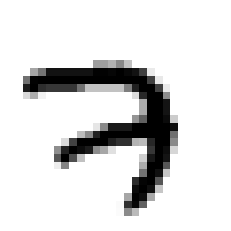

In [74]:
# Plot an image using Matplotlib's imshow() function, with a 'binary' color map:

plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

In [75]:
# The labels are the class IDs (represented as uint8), from 0 to 9. 
# Conveniently, the class IDs correspond to the digits represented in the images, so we don't need a class_names array:

y_train

array([7, 3, 4, ..., 5, 6, 8], dtype=uint8)

In [76]:
# The validation set contains 5,000 images, and the test set contains 10,000 images:

X_valid.shape

(5000, 28, 28)

In [77]:
X_test.shape

(10000, 28, 28)

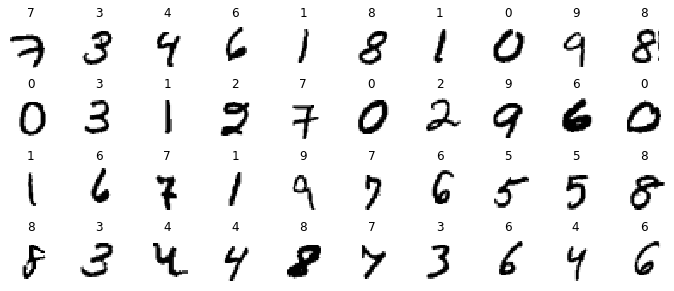

In [78]:
# A look at a sample of the images in the dataset:

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [79]:
# Building a simple dense network and find the optimal learning rate. 
# We will need a callback to grow the learning rate at each iteration. 
# It will also record the learning rate and the loss at each iteration:

K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

In [80]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [81]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [82]:
# Start with a small learning rate of 1e-3, and grow it by 0.5% at each iteration:

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
expon_lr = ExponentialLearningRate(factor=1.005)

In [83]:
# Train the model for just 1 epoch:

history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

Train on 55000 samples, validate on 5000 samples
55000/55000 [==============================] - 5s 90us/sample - loss: nan - accuracy: 0.6401 - val_loss: nan - val_accuracy: 0.0958


Text(0, 0.5, 'Loss')

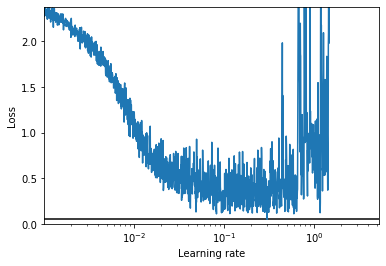

In [84]:
# Plotting the loss as a function of the learning rate:

plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.xlabel("Learning rate")
plt.ylabel("Loss")

In [85]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [86]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(400, activation="relu"),
    keras.layers.Dense(200, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [87]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=2e-1),
              metrics=["accuracy"])

In [88]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [89]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[early_stopping_cb, checkpoint_cb])

Train on 55000 samples, validate on 5000 samples
Epoch 1/100
55000/55000 [==============================] - 4s 74us/sample - loss: 0.2262 - accuracy: 0.9310 - val_loss: 0.1196 - val_accuracy: 0.9622
Epoch 2/100
55000/55000 [==============================] - 4s 70us/sample - loss: 0.0901 - accuracy: 0.9724 - val_loss: 0.0801 - val_accuracy: 0.9792
Epoch 3/100
55000/55000 [==============================] - 4s 71us/sample - loss: 0.0593 - accuracy: 0.9809 - val_loss: 0.0789 - val_accuracy: 0.9780
Epoch 4/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0421 - accuracy: 0.9868 - val_loss: 0.0785 - val_accuracy: 0.9774
Epoch 5/100
55000/55000 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.99 - 4s 68us/sample - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.0883 - val_accuracy: 0.9736
Epoch 6/100
55000/55000 [==============================] - 4s 69us/sample - loss: 0.0180 - accuracy: 0.9946 - val_loss: 0.0820 - val_accuracy: 0.9790
Epoch 7/1

In [90]:
model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 0s 37us/sample - loss: 0.0618 - accuracy: 0.9846


[0.06175286688434649, 0.9846]

In [ ]:
# Revert back to the given activation functions that were used in part 1. Now add 100 neurons to each hidden layer.

# What are the dimensions of this deep network?
#       We have 1 input Flatten layer
#       Next we have a Dense hidden layer with 400 neurons and a second Dense hidden layer with 200 neurons.
#       Then we have a Dense output layer with 10 neurons (one per class)

# What accuracy did you observe when the test data was checked?
#       Now the accuracy is 98.46%